## Предсказание количества заказов такси в аэропортах


## Данные

В наличие был один датасет с данными о количестве заказов в опрределенное время

## Задача
Необходимо построить модель, которая спрогнозирует количесво заказов такси в аэропортах на следующий час.  

## Навыки и инструменты
*pandas, sklearn, catboost, xgboost, lightgbm hyperopt, pandas_profiling, numpy, Matplotlib, StatsModels,
машинное обучение*

## Описание проекта
Проанализированы исторические данные о заказах такси в аэропортах.  
Спрогнозировано количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. 
Построена модель для такого предсказания.

In [1]:
#Заблокируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import sklearn
import datetime
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import calendar
pd.set_option('display.max_columns', 100)# можно не 100, а none
pd.set_option('display.max_rows', 100)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pandas_profiling
from pandas_profiling import ProfileReport

# 1. Подготовка

## 1.1. Загрузка и изучение данных

Загрузим и посмотрим данные

In [3]:
order_taxi = pd.read_csv("taxi.csv")
#order_taxi = pd.read_csv("taxi.csv")
print(order_taxi.shape)
print(order_taxi.info())
order_taxi.head()

(26496, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Посмотрим на данные более пристально. Воспользуемся для этого библиотекой pandas-profiling.

In [4]:
profile = ProfileReport(order_taxi, minimal = False)

In [5]:
profile.to_file(output_file = "order_taxi.html")

Здесь прикрепляю ссылку на результат - https://yadi.sk/d/CZfmT1mqUiZXHw (Для просмотра лучше открывать в яндекс браузере)

Подсчет % пропусков

In [6]:
(order_taxi.isnull().sum()/order_taxi.shape[0]*100).sort_values(ascending = False).head(50)

num_orders    0.0
datetime      0.0
dtype: float64

Подсчет % нулевых значений

In [7]:
(order_taxi[order_taxi == 0].count()/order_taxi.shape[0]*100).sort_values(ascending = False).head(50)

num_orders    2.026721
datetime      0.000000
dtype: float64

Итак мы видим, датасет состоящий из 26496 строк и 2 столбцов. Один столбец имеет вид дата-времени, но представлен в виде строки (object). Второй столбец представлен целыми числами. Можно выделить следующие особенности даноого датасета:
* Пропусков нет
* Дубликатов нет
* Нулевые значения имеются в столбце "num_orders", но для количества заказов такое может быть

## 1.2. Ресемплирование

Времнные интервалы в датасете представлены 10-ти минутными орезками, а нам нужно сделать предсказания для одного часа. Для этого нужно провести ресемплирование по одному часу

Сначало переведем данные в столбце datetime в тип datetime  

In [8]:
order_taxi['datetime'] = pd.to_datetime(order_taxi['datetime'], format='%Y-%m-%dT%H:%M:%S')
print(order_taxi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


Установим индекс таблицы равным столбцу datetime

In [9]:
order_taxi = order_taxi.set_index('datetime')
print(order_taxi.info())
print(order_taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]


Посморим, в хронологическом ли порядке расположены даты и время

In [10]:
print(order_taxi.index.is_monotonic)

True


Да, все Ок!
Теперь можно провести ресемплирование

In [11]:
order_taxi = order_taxi.resample('1H').sum() 

# 2. Анализ

Посмотрим на график динамики заказов

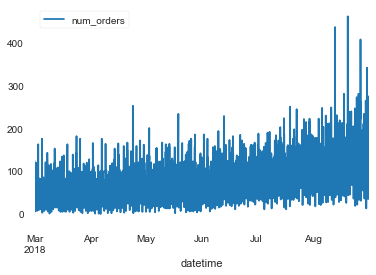

In [12]:
order_taxi.plot()

Проверим тренды и сезонность

Посмотрим на график после применения скользящего среднего

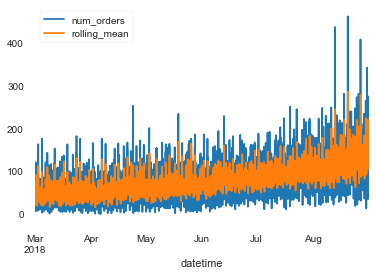

In [13]:
order_taxi['rolling_mean'] = order_taxi.rolling(5).mean()
order_taxi.plot()

Видим тренд увеличения заказов с весны к концу лета. Посмотрим на заказы более пристально через двухнедельный срез данных.

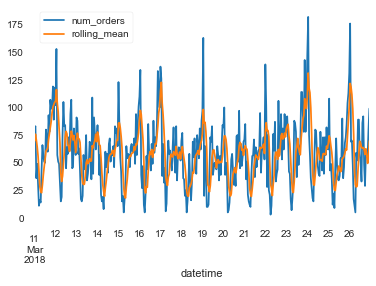

In [14]:
order_taxi['2018-03-11':'2018-03-26'].plot()

Тот же срез даных при ресемплировании по дням

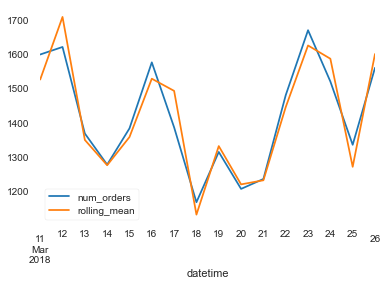

In [15]:
order_taxi_day = order_taxi.resample('d').sum()
order_taxi_day['2018-03-11':'2018-03-26'].plot()

Видим, что прослеживаеся сезонность. Уменьшим интервал.

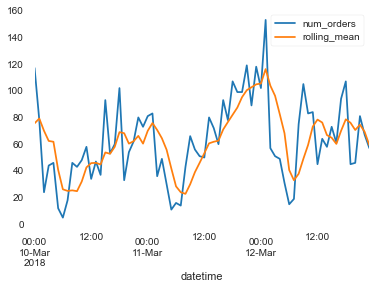

In [16]:
order_taxi['2018-03-10':'2018-03-12'].plot()

Видим явную периодичность изменения количесва заказов в течении суток и недели - увеличие количесва заказов в вечернее время с пиками в районе 24 часов и увеличение количества заказов в определеные дни недели: резко в понедельник и плавный роскт к пятнице. Посмотрим на тренды и сезонность через разложение временного ряда на тренд и сезонную компоненту. 

Ресемплирование по часу

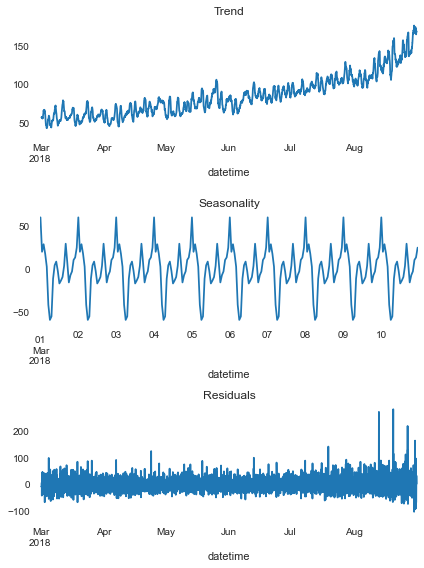

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
decomposed = seasonal_decompose(order_taxi["num_orders"])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Ресемплирование по дням

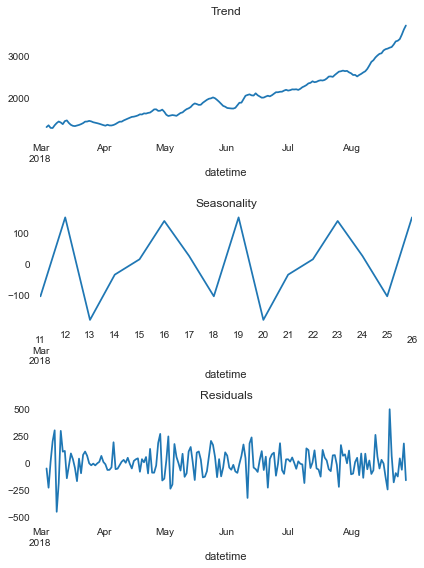

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
decomposed = seasonal_decompose(order_taxi_day["num_orders"])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-11':'2018-03-26'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Предположения подтвердились: есть суточная и дневная сезоннотсь и возрастающий тренд в течении наблюдаемого периода.

Действительно, видим, что есть и тренд и сезонность

# 3. Обучение

## 3.1. Подготовка данных

Удалим лишние признаки из датасета

In [20]:
order_taxi = pd.DataFrame(order_taxi["num_orders"])

In [21]:
order_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Напишем функцию make_features(), чтобы прибавить к таблице новые признаки:
* месяц
* день
* час
* день недели
* отстающие значения (max_lag)
* скользящее среднее (rolling_mean_size)



* Месяц включил в признаки, поскольку графичкский анализ показал, что есть тред - от месяца к месяцу, в пределах наблюдаемого интервала, количество заказов растет. (Пробовал месяц убирать из признаков. Качество прогноза ухудшается)
* День недели включил в признаки по той причине, что в анализе была показана недельная сезонность в заказах в зависимлсти от дня недели
* Час включил в признаки по той причине, что в анализе была показана суточная сезонность в заказах по часам
* max_lag: «Отстающие значения» - это так называемый фактор авторегрессии - предыдущие значения временного ряда.
* rolling_mean_size: Скользящее среднее как признак задаёт общий тренд временного ряда. Он какбы сглаживает случайные колебания, также улучшая пргноз  

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

Определим с помощью линейной регрессии лучшие парамтры max_lag и rolling_mean_size

In [24]:
parametrs = pd.DataFrame([])
for i in range(1, 10):
    for j in range(1, 10):
        order_taxi = pd.read_csv("taxi.csv")
        #order_taxi = pd.read_csv("taxi.csv")
        order_taxi['datetime'] = pd.to_datetime(order_taxi['datetime'], format='%Y-%m-%dT%H:%M:%S')
        order_taxi = order_taxi.set_index('datetime')
        order_taxi = order_taxi.resample('1H').sum() 
        make_features(order_taxi, i, j)
        order_taxi = order_taxi.dropna()
        
        comm, test = train_test_split(order_taxi, shuffle=False, test_size=0.1)
        train, valid = train_test_split(comm, shuffle=False, test_size=0.11)

        target_train = train['num_orders']
        features_train = train.drop(['num_orders'],  axis=1)

        target_valid = valid['num_orders']
        features_valid = valid.drop(['num_orders'],  axis=1)

        target_test = test['num_orders']
        features_test = test.drop(['num_orders'],  axis=1)
        
        model = LinearRegression()
        model.fit(features_train, target_train)
        predicted_train = model.predict(features_train)
        predicted_valid = model.predict(features_valid)
       
    
        parametrs = parametrs.append(pd.DataFrame({"max_lag": [i],
                                               "rolling_mean_size": [j],
                                               "RMSE валидационной выборки": [np.sqrt(mean_squared_error(target_valid, predicted_valid))],
                                              }))
parametrs.sort_values("RMSE валидационной выборки")

,max_lag,rolling_mean_size,RMSE валидационной выборки
0,9,7,40.314311
0,9,9,40.320934
0,9,4,40.328423
0,9,3,40.340808
0,9,8,40.348286
0,9,5,40.369645
0,9,6,40.393551
0,9,2,40.418123
0,8,9,40.419910
0,7,9,40.425679


По таблице после ранжирования RMSE валидационной выборки определяем лучшие параметры max_lag и rolling_mean_size. В нашем случае это 9 и 7 соответсвенно. Далее именно их я закрепляю при создании признаков. Их дальше и будем использовать при формировании признаков. Создадим их.

In [26]:
order_taxi = pd.read_csv("taxi.csv")
order_taxi['datetime'] = pd.to_datetime(order_taxi['datetime'], format='%Y-%m-%dT%H:%M:%S')
order_taxi = order_taxi.set_index('datetime')
order_taxi = order_taxi.resample('1H').sum() 
make_features(order_taxi, 9, 7)
order_taxi = order_taxi.dropna()
order_taxi

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,34.714286
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,42.285714
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,45.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,167.428571
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,167.428571
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,165.714286


## 3.2. Обучение моделей

### 3.2.1. Линейная регрессия

Обучим линейную регрессию. Для обучения будем использовать объединенную выборку из feaures_train и feaures_valid, потому ,что выборки небольшие и чтобы не разрывать временной ряд. Аналогично я буду поступать и для других моделей.

In [27]:
comm, test = train_test_split(order_taxi, shuffle=False, test_size=0.1)
train, valid = train_test_split(comm, shuffle=False, test_size=0.11)

target_train = train['num_orders']
features_train = train.drop(['num_orders'],  axis=1)

target_valid = valid['num_orders']
feaures_valid = valid.drop(['num_orders'],  axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'],  axis=1)

target_comm = comm['num_orders']
features_comm = comm.drop(['num_orders'],  axis=1)

In [28]:
model_param = pd.DataFrame([])
LR = LinearRegression()
LR.fit(features_comm, target_comm)
predicted_train = LR.predict(features_train)
predicted_valid = LR.predict(feaures_valid)
       
model_param = model_param.append(pd.DataFrame({"model": ["LinearRegression"],
                                               "iterations": [""],
                                               "learning_rate": [""],
                                               "RMSE_train": [np.sqrt(mean_squared_error(target_train, predicted_train))],
                                               "RMSE_val": [np.sqrt(mean_squared_error(target_valid, predicted_valid))],
                                               "Overfit": [np.sqrt(mean_squared_error(target_train, predicted_train)) - np.sqrt(mean_squared_error(target_valid, predicted_valid))],   
                                               }))
model_param

,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,LinearRegression,,,28.795598,39.943985,-11.148387


### 3.2.2. RandomForestRegressor

Подберем параметры для RandomForestRegressor с помощью GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(random_state=12345)

parametrs = {"n_estimators": range(70, 100, 10), "max_depth": range(10, 20, 3)}
grid_search_cv_model = GridSearchCV(model, parametrs, cv = 5)
grid_search_cv_model

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
          

In [30]:
grid_search_cv_model.fit(features_comm, target_comm)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
          

In [31]:
grid_search_cv_model.best_params_

{'max_depth': 19, 'n_estimators': 90}

In [32]:
RandomForestRegressor = grid_search_cv_model.best_estimator_
RandomForestRegressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [33]:
RandomForestRegressor.fit(features_comm, target_comm)
predicted_train = RandomForestRegressor.predict(features_train)
predicted_valid = RandomForestRegressor.predict(feaures_valid)
        
model_param = model_param.append(pd.DataFrame({"model": ["RandomForestRegressor"],
                                               "iterations": [""],
                                               "learning_rate": [""],
                                               "RMSE_train": [np.sqrt(mean_squared_error(target_train, predicted_train))],
                                               "RMSE_val": [np.sqrt(mean_squared_error(target_valid, predicted_valid))],
                                               "Overfit": [np.sqrt(mean_squared_error(target_train, predicted_train)) - np.sqrt(mean_squared_error(target_valid, predicted_valid))],   
                                               }))
model_param


,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,LinearRegression,,,28.795598,39.943985,-11.148387
0,RandomForestRegressor,,,8.063051,11.935192,-3.872142


### 3.2.3. CatBoost

In [34]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

Подготовим данные для CatBoost. Разделим дата сет на обучающую, валидационную и тестовую выборки

In [35]:
df_com, df_test = train_test_split(order_taxi, shuffle=False, test_size=0.1, random_state=12345)
df_train, df_val = train_test_split(df_com, shuffle=False, test_size=0.1, random_state=12345)

Сформируем наборы данных для обучния

In [36]:
train_pool = Pool(df_train.drop(['num_orders'],  axis=1),
                  label=df_train.num_orders.values)

In [37]:
val_pool = Pool(df_val.drop(['num_orders'],  axis=1),
                label=df_val.num_orders)

In [38]:
test_pool = Pool(df_test.drop(['num_orders'],  axis=1),
                label=df_test.num_orders)

In [39]:
df_com_pool = Pool(df_com.drop(['num_orders'],  axis=1),
                label=df_com.num_orders)

Подберем лучшие параметры для модели спомощью библиотеки hyperopt

In [40]:
import hyperopt
import catboost as ctb
from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials

ctb_reg_params = {
    'learning_rate':  hp.quniform('learning_rate', 0.01, 0.3, 0.02),
    'max_depth': hp.quniform('max_depth', 1, 6, 1),
    'n_estimators': hp.quniform('n_estimators', 400, 1000, 100),
    'eval_metric': 'RMSE',
}

ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}
    

obj =  HPOpt( df_train.drop(['num_orders'], 1), df_val.drop(['num_orders'], 1), df_train.num_orders, df_val.num_orders)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


print('best:')
print(ctb_opt)

100%|██████| 100/100 [01:36<00:00,  1.04trial/s, best loss: 31.376927233960362]
best:
({'learning_rate': 0.26, 'max_depth': 5.0, 'n_estimators': 800.0}, <hyperopt.base.Trials object at 0x0000000019B6AE88>)


Обучим модели и сохрамим параметры их обучния и предсказания

In [41]:
model_1 = CatBoostRegressor(objective='RMSE', max_depth = 5, iterations = 900, learning_rate = 0.26, random_seed = 12345, train_dir= "learning_rate = 0.05")
model_2 = CatBoostRegressor(objective='RMSE', max_depth = 5, iterations = 700, learning_rate = 0.2, random_seed = 12345, train_dir= "learning_rate = 0.1")
model_3 = CatBoostRegressor(objective='RMSE', max_depth = 5, iterations = 600, learning_rate = 0.1, random_seed = 12345, train_dir = "learning_rate = 0.2")
model_4 = CatBoostRegressor(objective='RMSE', max_depth = 5, iterations = 500, learning_rate = 0.05, random_seed = 12345, train_dir = "learning_rate = 0.2_2")

for models in (model_1, model_2, model_3, model_4):
    
    
    models.fit(df_com_pool, plot=False, eval_set=val_pool, verbose=False)
 
    
    rmse_train = np.sqrt(mean_squared_error(df_train.num_orders.values, models.predict(train_pool)))
    rmse_val = np.sqrt(mean_squared_error(df_val.num_orders.values, models.predict(val_pool)))
    
    
    actual_counts = df_test.num_orders.values
    predicted_counts_poisson = models.predict(test_pool)
 
    
    rmse_test = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
         
    model_param = model_param.append(pd.DataFrame({"model": ["CatBoost"],
                                               "iterations": [pd.Series(models.get_params())["iterations"]],
                                               "learning_rate": [pd.Series(models.get_params())["learning_rate"]],
                                               "RMSE_train": [rmse_train],
                                               "RMSE_val": [rmse_val],
                                               "Overfit": [rmse_val - rmse_train],   
                                               }))
    

model_param

,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,LinearRegression,,,28.795598,39.943985,-11.148387
0,RandomForestRegressor,,,8.063051,11.935192,-3.872142
0,CatBoost,900,0.26,6.263038,4.274265,-1.988772
0,CatBoost,700,0.2,9.187416,6.685885,-2.501531
0,CatBoost,600,0.1,13.738360,12.700151,-1.038209
0,CatBoost,500,0.05,17.345519,19.160338,1.814819


### 3.2.4. LightGBM

In [42]:
import lightgbm as lgb
import pickle
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

Создадим следующие переменные:
* pred_cols-это столбец с целевой пееменной
* num_cols-это числовые столбцы, которые будут использоваться при обучении модели

In [43]:
cat_cols = []
pred_cols = ['num_orders']
num_cols = [x for x in list(order_taxi.columns.values) if x not in cat_cols]

In [44]:
data_final = order_taxi

Разделим дата сет на обучающую, валидационную и тестовую выборки

In [45]:
df_com, test_final = train_test_split(order_taxi, shuffle=False, test_size=0.1, random_state=12345)
train_final, val_final = train_test_split(df_com, shuffle=False, test_size=0.11, random_state=12345)

Создадим обучающие и целевые наборы данных для тренровочного и валидационного множества

In [46]:
y_train = train_final['num_orders']
y_val = val_final['num_orders']
y_test = test_final['num_orders']
y_com = df_com['num_orders']

x_train = train_final.drop(['num_orders'], axis=1)
x_val = val_final.drop(['num_orders'], axis=1)
x_test = test_final.drop(['num_orders'], axis=1)
x_com = df_com.drop(['num_orders'], axis=1)

In [47]:
lgb_train = lgb.Dataset(data = x_train, label = y_train, free_raw_data = False)
lgb_val = lgb.Dataset(data = x_val, label = y_val, reference = lgb_train, free_raw_data = False)
lgb_test = lgb.Dataset(data = x_test, label = y_test, free_raw_data = False)
lgb_com = lgb.Dataset(data = x_com, label = y_com, free_raw_data = False)


Обучим модели и сохрамим параметры их обучния и предсказания. Не будем использовать hyperopt для подбора параметров, поскольку предыдущая работа показала, что они похожи у моделей CatBoost, LightGBM и XGBoost. Кроме того мы все равно берем несколько наборов параметров, чтобы выбрать лучший.

In [48]:
learning_rate = (0.05, 0.1, 0.2, 0.26)
n_estimators = (500, 600, 700, 900)

for learning_rate, n_estimators in zip(learning_rate, n_estimators):
    params = {'boosting_type': 'dart',
          'objective': 'regression',
          'metric': 'RMSE',
          "random_seed": 12345,
          'max_depth': 6,
          'learning_rate': learning_rate,
          'n_estimators': n_estimators,
          
         }
    
    start_time = time.clock()
    gbm = lgb.train(params, train_set = lgb_com,
                valid_sets = [lgb_val],
                valid_names = ['eval'],
                verbose_eval = False
               )

   
    
    rmse_train = np.sqrt(mean_squared_error(train_final.num_orders.values, gbm.predict(x_train, num_iteration = gbm.best_iteration)))
    rmse_val = np.sqrt(mean_squared_error(val_final.num_orders.values, gbm.predict(x_val, num_iteration = gbm.best_iteration)))
    
          
    
    actual_counts = test_final.num_orders.values
    predicted_counts_poisson = gbm.predict(x_test, num_iteration = gbm.best_iteration)
    
    
    rmse_test = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
         
    model_param = model_param.append(pd.DataFrame({"model": ["LightGBM"],
                                               "iterations": [n_estimators],
                                               "learning_rate": [learning_rate],
                                               "RMSE_train": [rmse_train],
                                               "RMSE_val": [rmse_val],
                                               "Overfit": [rmse_val - rmse_train],
                                                
                                               }))
    
model_param

,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,LinearRegression,,,28.795598,39.943985,-11.148387
0,RandomForestRegressor,,,8.063051,11.935192,-3.872142
0,CatBoost,900,0.26,6.263038,4.274265,-1.988772
0,CatBoost,700,0.2,9.187416,6.685885,-2.501531
0,CatBoost,600,0.1,13.738360,12.700151,-1.038209
0,CatBoost,500,0.05,17.345519,19.160338,1.814819
0,LightGBM,500,0.05,17.417198,24.268312,6.851114
0,LightGBM,600,0.1,12.850360,15.469520,2.619160
0,LightGBM,700,0.2,9.443601,9.998987,0.555386
0,LightGBM,900,0.26,6.936814,6.567019,-0.369795


Ниже находится закомментированный блок, который позволяет использовать кросс-валидацию для подбора параметров LightGBM. Он существенно увеличивает время работы модели, поэтому я его упростил, но оставил, чтобы не потерялся.

In [49]:
# depth = 8
# num_leaves = 2**depth - 1
# learning_rate = (0.05, 0.1, 0.2, 0.2)
# n_estimators = (100, 300, 500, 700)

# for learning_rate, n_estimators in zip(learning_rate, n_estimators):
#     params = {'boosting_type': 'dart',
#           'objective': 'regression',
#           'metric': 'RMSE',
#           'num_leaves': num_leaves,
#           'max_depth': 5,
#           'random_seed': 12345,
#           'learning_rate': learning_rate,
#           'n_estimators': n_estimators,
#           'min_split_gain': 0.05,
#           'min_child_weight': 0.5,
#           'subsample': 0.8,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.2,
#           'reg_lambda': 0.2,
#           'drop_rate': 0.2,
#           'skip_drop': 0.8,
#           'max_drop': 200,
#           'seed': 100,
#           'silent': False
#          }
    
#     start_time = time.clock()
#     num_boost_round = 100
#     early_stopping_rounds = 10
#     nfold = 5
#     evals_result = {}

#     gbmCV = lgb.cv(params,
#                train_set = lgb_train,
#                num_boost_round = num_boost_round,
#                nfold = nfold,
#                early_stopping_rounds = early_stopping_rounds,
#                verbose_eval = False)

#     num_boost_round = len(gbmCV['rmse-mean'])

#     gbm = lgb.train(params,
#                 train_set = lgb_train,
#                 num_boost_round = num_boost_round,
#                 valid_sets = [lgb_val],
#                 valid_names = ['eval'],
#                 evals_result = evals_result,
#                 verbose_eval = False)

#     time_learn = time.clock() - start_time
    
#     rmse_train = np.sqrt(mean_squared_error(train_final.num_orders.values, gbm.predict(x_train, num_iteration = gbm.best_iteration)))
#     rmse_val = np.sqrt(mean_squared_error(val_final.num_orders.values, gbm.predict(x_val, num_iteration = gbm.best_iteration)))
    
          
#     start_time = time.clock()
#     actual_counts = test_final.num_orders.values
#     predicted_counts_poisson = gbm.predict(x_test, num_iteration = gbm.best_iteration)
#     time_pred = time.clock() - start_time
    
#     rmse_test = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
         
#     model_param = model_param.append(pd.DataFrame({"model": ["LightGBM"],
#                                                "iterations": [n_estimators],
#                                                "learning_rate": [learning_rate],
#                                                "time_learn": [time_learn],
#                                                "time_pred": [time_pred],
#                                                "RMSE_train": [rmse_train],
#                                                "RMSE_val": [rmse_val],
#                                                "Overfit": [rmse_val - rmse_train],
#                                                "RMSE_test": [rmse_test] 
#                                                }))
    
# model_param

### 2.3. XGBoost

In [50]:
import xgboost as xgb

Воспользуемся для обучения и тестирования модели теми же наборами данных, что и для LightGBM. 

In [51]:
learning_rate = (0.05, 0.1, 0.26, 0.26)
n_estimators = (500, 600, 700, 900)


for learning_rate, n_estimators in zip(learning_rate, n_estimators):
    
    xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=1, gamma=0,
    importance_type='gain', learning_rate=learning_rate, max_delta_step=0,
    max_depth=6, min_child_weight=1, missing=None, n_estimators=n_estimators,
    n_jobs=-1, nthread=None, objective='reg:linear', random_state=12345,
    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    silent=None, subsample=1, verbosity=1)
    
      
    xgbr.fit(x_com, y_com)
    
    
    rmse_train = np.sqrt(mean_squared_error(y_train, xgbr.predict(x_train)))
    rmse_val = np.sqrt(mean_squared_error(y_val, xgbr.predict(x_val)))
     
         
    model_param = model_param.append(pd.DataFrame({"model": ["XGBoost"],
                                               "iterations": [n_estimators],
                                               "learning_rate": [learning_rate],
                                               "RMSE_train": [rmse_train],
                                               "RMSE_val": [rmse_val],
                                               "Overfit": [rmse_val - rmse_train]
                                                }))
    
model_param

[12:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:16

,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,LinearRegression,,,28.795598,39.943985,-11.148387
0,RandomForestRegressor,,,8.063051,11.935192,-3.872142
0,CatBoost,900,0.26,6.263038,4.274265,-1.988772
0,CatBoost,700,0.2,9.187416,6.685885,-2.501531
0,CatBoost,600,0.1,13.738360,12.700151,-1.038209
0,CatBoost,500,0.05,17.345519,19.160338,1.814819
0,LightGBM,500,0.05,17.417198,24.268312,6.851114
0,LightGBM,600,0.1,12.850360,15.469520,2.619160
0,LightGBM,700,0.2,9.443601,9.998987,0.555386
0,LightGBM,900,0.26,6.936814,6.567019,-0.369795


Определим три модели с самыми низкими показателями RMSE на валидационной выборке. 

In [52]:
model_param.sort_values("RMSE_val")

,model,iterations,learning_rate,RMSE_train,RMSE_val,Overfit
0,XGBoost,900,0.26,0.012470,0.006588,-0.005881
0,XGBoost,700,0.26,0.063402,0.028519,-0.034883
0,XGBoost,600,0.1,2.706212,1.416420,-1.289792
0,CatBoost,900,0.26,6.263038,4.274265,-1.988772
0,XGBoost,500,0.05,8.052914,5.623311,-2.429603
0,LightGBM,900,0.26,6.936814,6.567019,-0.369795
0,CatBoost,700,0.2,9.187416,6.685885,-2.501531
0,LightGBM,700,0.2,9.443601,9.998987,0.555386
0,RandomForestRegressor,,,8.063051,11.935192,-3.872142
0,CatBoost,600,0.1,13.738360,12.700151,-1.038209


# 4. Тестирование

Посмотрим на метрику RMSE на тестовой выборке для лучших моделей, определенных выше.

In [53]:
learning_rate = (0.26, 0.2, 0.1)
n_estimators = (900, 700, 600)

RSME_test = pd.DataFrame([])
for learning_rate, n_estimators in zip(learning_rate, n_estimators):
    
    xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=1, gamma=0,
    importance_type='gain', learning_rate=learning_rate, max_delta_step=0,
    max_depth=6, min_child_weight=1, missing=None, n_estimators=n_estimators,
    n_jobs=-1, nthread=None, objective='reg:linear', random_state=12345,
    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    silent=None, subsample=1, verbosity=1)
    
      
    xgbr.fit(x_com, y_com)



    actual_counts = test_final.num_orders.values
    predicted_counts_poisson = xgbr.predict(x_test)
    
       
    RSME_test = RSME_test.append(pd.DataFrame({"model": ["XGBoost"],
                                               "iterations": [n_estimators],
                                               "learning_rate": [learning_rate],
                                               "RMSE_test": [np.sqrt(mean_squared_error(y_test, predicted_counts_poisson))],
                                               }))
    
RSME_test

[12:05:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:16

,model,iterations,learning_rate,RMSE_test
0,XGBoost,900,0.26,43.411767
0,XGBoost,700,0.20,46.492762
0,XGBoost,600,0.10,45.563429


Выводы:
* Были обучены 5 моделей с разными гиперпараметрами
* Определены самые эффективные модели по валидационной выборке
* Все они прошли порог RSME на тестовой выборке в 48 пунктов
* Преобучение данных моделей минимальное